# 06. PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of thwat one model has learned on another dataset and applying them to our own problem.

* Pretrained model = foundation models

In [2]:
try:
    import torch
    import torchvision

    major = int(torch.__version__.split(".")[0])
    minor = int(torch.__version__.split(".")[1])
    assert (major >= 2) or (minor >= 12), "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.0.dev20230910+cu121
torchvision version: 0.17.0.dev20230910+cu121


Now we've got the versions of torch and torchvision we're after, so now we'll import the code we wrote in last section

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

info_string = Style.BRIGHT + Fore.RED + "[INFO] " 
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print(info_string + "Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print(info_string + "Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

NameError: name 'Style' is not defined

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data

We need our pizza, steak, sushi data to build a transfer learning model on

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder does not exist download the data from GitHub
if image_path.is_dir():
    print(f"{image_path} directory exists, skipping re-download...")
else:
    print(f"Did not find {image_path}, we are downloading it now...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, and sushi
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data...")
        f.write(request.content)

    # Unzip the data
    with zipfile.Zipfile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping image data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path/ pizza_steak_sushi.zip)

data/pizza_steak_sushi directory exists, skipping re-download...


In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

Now we've got some data, and we want to turn it into PyTorch `DataLoader`s

To do so, we can use `data_setup.py` and the `create_dataloaders()` function
we created in 05

In [7]:
from going_modular import data_setup

### 2.1 Creating a transform for `torchvision.models` (manual creation)

> **Note:** As of `torchvision` v0.13+, there's an update to how data transforms can be created using `torchvision.models`. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation stated:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of: 

| **Transform number** | **Transform required** | **Code to perform transform** | 
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  | 

> **Note:** ^some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [8]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [9]:
train_dataloder, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)
train_dataloder, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fae1c0b1c30>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As previously stated, when using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Above we saw how to manually create a transform for a pretrained model.

But as of `torchvision` v0.13+, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:
    
```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many differnt model architecture options in `torchvision.models`).
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).
    * **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the [`torchvision.models` documentation](https://pytorch.org/vision/main/models.html) for more.
    
Let's try it out.

In [10]:
import torchvision

In [11]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the transforms used to create our pre-trained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create Dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fc65d388040>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Alright, here comes the fun part!

Over the past few notebooks we've been building PyTorch neural networks from scratch.

And while that's a good skill to have, our models haven't been performing as well as we'd like. 

That's where **transfer learning** comes in.

The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customising it to your use case**.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... | 
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` | 
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... | 
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... | 
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` | 

### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0()` -> `efficientnet_b1()` -> `efficientnet_b7()`) means *better performance* but a *larger* model.

You might think better performance is *always better*, right?

That's true but **some better performing models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as [*The Bitter Lesson*](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) states, you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.

For me, I've found a nice balance in the `efficientnet_bX` models. 

As of May 2022, [Nutrify](https://nutrify.app) (the machine learning powered app I'm working on) is powered by an `efficientnet_b0`.

[Comma.ai](https://comma.ai/) (a company that makes open source self-driving car software) [uses an `efficientnet_b2`](https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html) to learn a representation of the road.

> **Note:** Even though we're using `efficientnet_bX`, it's important not to get too attached to any one architecture, as they are always changing as new research gets released. Best to experiment, experiment, experiment and see what works for your problem. 

In [1]:
# New method of creating a pre-trained model
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model = torchvision.models.efficientnet_b1(weights=weights).to(device)
#model

NameError: name 'torchvision' is not defined

In [ ]:
model.features

In [15]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [16]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary with `torchinfo`

In [17]:
# Print summary with torchinfo
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width])
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png" alt="changing the efficientnet classifier head to a custom number of outputs" width=900/>

*You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original `torchvision.models.efficientnet_b0()` comes with `out_features=1000` because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need `out_features=3`.*

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [18]:
for param in model.features.parameters():
    param.requires_grad = False # Freeze the parameters in place, but keeps output layer trainable

Classifier Head is the output layer of the model which here is `Sequential (classifier)` and can be accessed via `model.classifier`

In [19]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)

# We access th replicate the classifier head (i.e., output layer)
# Dropout layer inactivates neurons at a rate of `p` to prevent overfitting
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True)).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [20]:
# Print summary with torchinfo
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width])
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|█████████                                    | 1/5 [00:01<00:04,  1.12s/it]

Epoch: 1 | train_loss: 0.6714 | train_acc: 0.9219 | test_loss: 0.6723 | test_acc: 0.9176


 40%|██████████████████                           | 2/5 [00:02<00:03,  1.11s/it]

Epoch: 2 | train_loss: 0.6227 | train_acc: 0.9492 | test_loss: 0.6270 | test_acc: 0.9384


 60%|███████████████████████████                  | 3/5 [00:03<00:02,  1.10s/it]

Epoch: 3 | train_loss: 0.5769 | train_acc: 0.9414 | test_loss: 0.5712 | test_acc: 0.9384


 80%|████████████████████████████████████         | 4/5 [00:04<00:01,  1.08s/it]

Epoch: 4 | train_loss: 0.5527 | train_acc: 0.9492 | test_loss: 0.5156 | test_acc: 0.9489


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.09s/it]

Epoch: 5 | train_loss: 0.5294 | train_acc: 0.9688 | test_loss: 0.5269 | test_acc: 0.9384
[INFO] Total training time: 5.458 seconds


In [23]:
results

{'train_loss': [1.0758983045816422,
  0.952294610440731,
  0.8611797168850899,
  0.804388590157032,
  0.7440433204174042],
 'train_acc': [0.421875, 0.80078125, 0.8515625, 0.7578125, 0.78125],
 'test_loss': [0.9913258751233419,
  0.9105080167452494,
  0.8264084657033285,
  0.7395090063412985,
  0.7063678105672201],
 'test_acc': [0.8162878787878788,
  0.9280303030303031,
  0.9384469696969697,
  0.9384469696969697,
  0.8977272727272728]}

In [24]:
## 5. Evaluate model by plotting loss curves

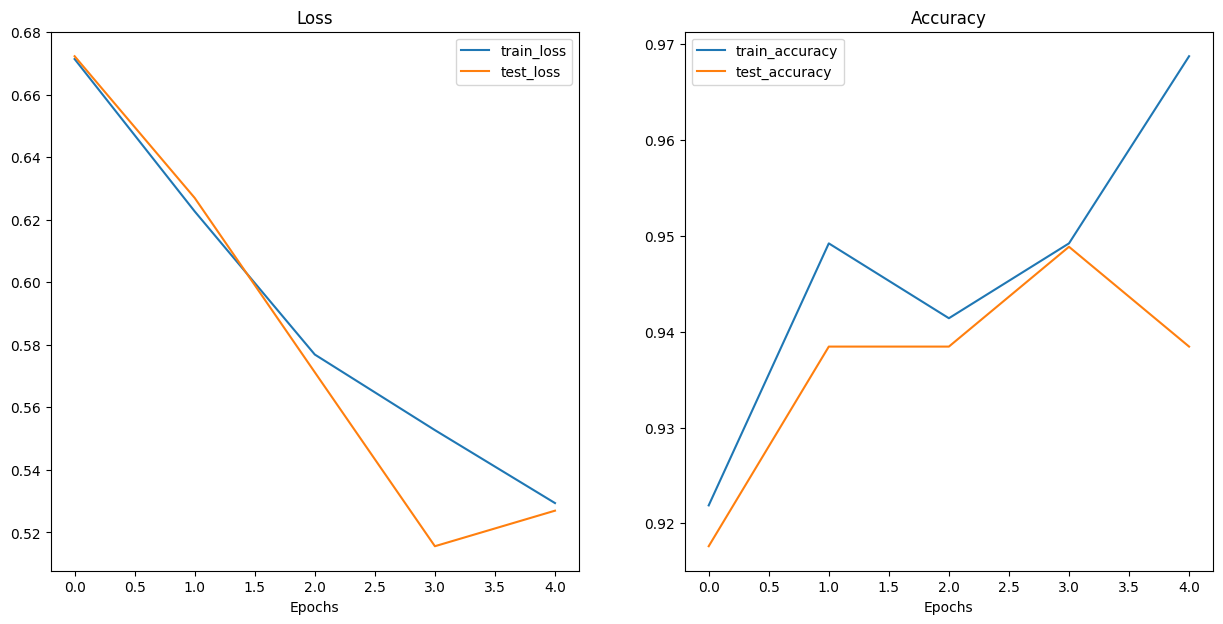

In [27]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading it...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

It looks like our model performs well quantitatively but how about qualitatively?

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

*Visualize, visualize, visualize!*

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

> **Note:** This is a similar function to [04. PyTorch Custom Datasets section 11.3's](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function) `pred_and_plot_image()` with a few tweaked steps. 

In [32]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms=None,
                        device="cpu"):
    # Open the image
    img = Image.open(image_path)

    # Use transform provided otherwise create a transform if one is not provided
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ])

    # Send model to the device
    model = model.to(device)

    # Turn on eval and inference mode
    model.eval()
    with torch.inference_mode():
        # Run the image through the transform and send it to the target device
        transformed_image = image_transform(img).unsqueeze(dim=0).to(device)
        print(f"{type(transformed_image)}")
        # Get Logits of our transformed image from our model
        target_image_pred = model(transformed_image)

    # Convert Logits to Prediction Probabilities  
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert Probabilities to Predicted Label
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


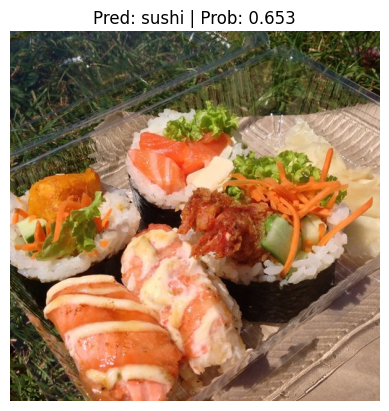

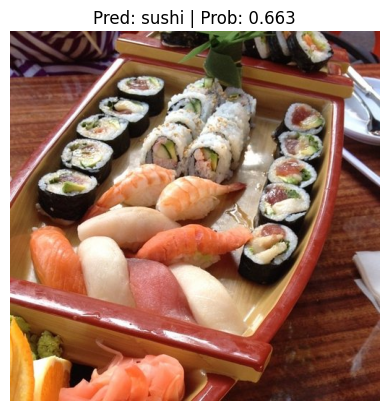

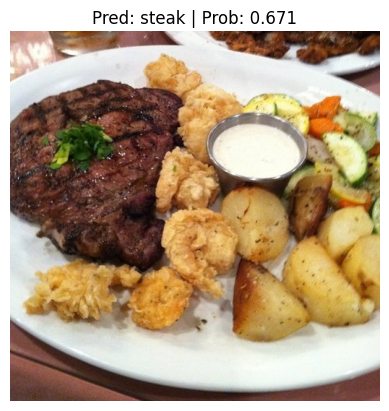

In [39]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                      k=num_images_to_plot)

# Make predictions on images and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224),
                        device=device)

File data/04-pizza-dad.jpeg already exists, skipping download, dog...
<class 'torch.Tensor'>


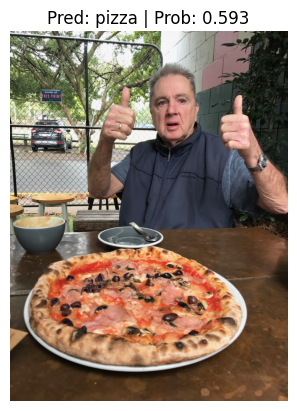

In [33]:
# Download a custom image
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        print(f"File {custom_image_path} does not exist, downloading now...")
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        f.write(request.content)
else:
    print(f"File {custom_image_path} already exists, skipping download, dog...")
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)